# Spatial Averaging in xarray and CDAT

This notebook will explore spatial averaging in CDAT and xarray. I will also try to [extend xarray](http://xarray.pydata.org/en/stable/internals.html#extending-xarray) using their datarray accessor functionality to build in simple spatial averaging in xarray. 

<span style="color:red">Note that CDAT takes into account cell boundaries to accurately calculate weighting in each grid cell (at least I think it does). I'm not going to try to reproduce that in xarray (I'll do simple `cos(lat)` weighting).</span>


## Imports

In [1]:
from scripts import xrw
from scripts import cdw
import xarray as xr
import cdms2
import cdutil
import numpy as np
import matplotlib.pyplot as plt
import time as clockTime

%matplotlib inline

/home/jovyan/conda-envs/xcdat/lib/python3.7/site-packages/pkg_resources/__init__.py:1243: UserWarning: Extraction path is writable by group/others and vulnerable to attack when used with get_resource_filename (/home/jovyan/.cache/Python-Eggs). Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


## Calculations using CDAT

### Start by getting XML files

In [2]:
xmlFiles = cdw.getXmlFiles(mip_era='CMIP6', experiment='historical', variable='tas', frequency='mon', verbose=False)

climlib.wrangle.getFileMeta: problem opening, file skipped:
 /p/user_pub/xclim//CMIP6/CMIP/historical/atmos/mon/tas/CMIP6.CMIP.historical.KIOST.KIOST-ESM.r1i1p1f1.mon.tas.atmos.glb-z1-gr1.v20191106.0000000.0.xml


CDAT had to skip a file: `cdscan` must have had an issue here.

I want to loop over models, so I'll start by getting a list of all models (by parsing the xml paths for model names). 

In [3]:
models = []
for fn in xmlFiles:
    model = fn.split('/')[-1].split('.')[4]
    models.append(model)
# de-duplicate list
models = list(set(models))
models.sort()

Now let's loop over all models and calculate the time series for the global, tropical, and Nino 3.4 regions. 

In [4]:
# create output dictionaries
n34_cdat = {}
trop_cdat = {}
global_cdat = {}

# loop over models and perform averaging calculations
cdatStart = clockTime.time()
for model in models:
    # subset model xml files
    modelXmlFiles = [fn for fn in xmlFiles if '.' + model + '.' in fn]
    # get first file and realization id
    fn = modelXmlFiles[0]
    rip = fn.split('.')[5]
    # load data from first file in list
    f = cdms2.open(fn)
    tas = f('tas')
    f.close()
    # global average
    tasg = cdutil.averager(tas, axis='xy', weights='weighted')
    # tropical average
    R1 = cdutil.region.domain(latitude=(-25, 25))
    tast = cdutil.averager(R1.select(tas), axis='xy', weights='weighted')
    # Nino 3.4 region
    R1 = cdutil.region.domain(latitude=(-5., 5.), longitude=(-170., -120.))
    n34 = cdutil.averager(R1.select(tas), axis='xy', weights='weighted')
    # put data into dictionary
    n34_cdat[model] = {rip: n34}
    trop_cdat[model] = {rip: tast}
    global_cdat[model] = {rip: tasg}
cdatEnd = clockTime.time()

ttotal = (cdatEnd - cdatStart) / 60.
tmin = int(np.floor(ttotal))
tsec = int((ttotal - np.floor(ttotal))*60)
ttotalstr = str(tmin) + ':' + "{:02d}".format(tsec)
print('CDAT operations took ' + ttotalstr + ' to complete')

CDAT operations took 14:01 to complete


## Calculations using xarray

### Start by getting paths to CMIP data

In [5]:
dpaths = xrw.get_cmip_paths(mip_era='CMIP6', experiment='historical', variable='tas', frequency='mon', verbose=False)

First I am going to register a custom class to extend an xarray dataset so that I can compute the spatial average directly.

In [6]:
@xr.register_dataset_accessor('geo')
class GeoAccessor:
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        self._get_weights = None

    def get_spatial_average(self,
                            vid,
                            latBnds=[-90., 90.],
                            lonBnds=[0., 360.]):
        try:
            data = self._obj[vid].sel(latitude=slice(latBnds[0], latBnds[1]),
                                      longitude=slice(lonBnds[0], lonBnds[1]))
            lat = self._obj[vid].latitude
        except:
            data = self._obj[vid].sel(lat=slice(latBnds[0], latBnds[1]),
                                      lon=slice(lonBnds[0], lonBnds[1]))
            lat = self._obj[vid].lat
        latbnds = self.get_lat_bounds()
        # this is a hack...
        if len(latbnds.shape) > 2:
            latbnds = latbnds[0, :, :]
        weights = self.get_weights(latbnds)
        weights[np.isnan(weights)] = 0.
        Ix = np.where((np.array(lat) <= latBnds[1]) & (np.array(lat) >= latBnds[0]))[0]
        try:
            weights = weights.isel(lat=Ix)
            wdata = data.weighted(weights)
            ts = wdata.mean(('lon', 'lat'))
        except:
            weights = weights.isel(latitude=Ix)
            wdata = data.weighted(weights)
            ts = wdata.mean(('longitude', 'latitude'))
        return ts

    def get_weights(self, latbnds):
        """Get weights for rectilinear grid."""
        slat = np.sin(latbnds * np.pi / 180.)
        weights = np.abs(slat[:, 0] - slat[:, 1])
        weights.name = 'weights'
        return weights

    def get_lat_bounds(self):
        """Get weights for rectilinear grid."""
        vlist = list(self._obj.keys())
        if 'lat_bnds' in vlist:
            latbnds = self._obj.lat_bnds
        elif 'latitude_bnds' in vlist:
            latbnds = self._obj.latitude_bnds
        else:
            # get latitude
            for v in vlist:
                clist = list(ds[v].coords)
                if 'lat' in clist:
                    lat = np.array(self._obj[v].lat)
                elif 'latitude' in clist:
                    lat = self._obj[v].latitude
                else:
                    continue
            lat_mid = np.array((np.array(lat[1:]) + np.array(lat[0:-1])) / 2.)
            latbnds = np.zeros((len(lat), 2))
            if np.sign(lat[0]) < 0:
                latbnds[:, 0] = np.concatenate(([-90], lat_mid))
                latbnds[:, 1] = np.concatenate((lat_mid, [90]))
            else:
                latbnds[:, 0] = np.concatenate(([90], lat_mid))
                latbnds[:, 1] = np.concatenate((lat_mid, [-90]))
            latbnds = xr.DataArray(latbnds,
                                   coords=[lat, [0, 1]],
                                   dims=['lat', 'nbnd'],
                                   attrs={'units': 'degrees_north'})
        return latbnds

Now loop over data paths and perform same calculation with xarray. 

In [7]:
# create output dictionaries
n34_xarray = {}
trop_xarray = {}
global_xarray = {}

xarrayStart = clockTime.time()
for model in models:
    modelPaths = [p for p in dpaths if '/' + model + '/' in p]
    # get same variant as CDAT
    rip = list(n34_cdat[model].keys())[0]
    dpath = [p for p in modelPaths if '/' + rip + '/' in p]
    # open data
    ds = xr.open_mfdataset(dpath[0] + '*', combine='by_coords')
    ds.load()  # load into memory
    # take global weighted average
    tasg = ds.geo.get_spatial_average('tas').load()
    # take tropical weighted average
    tast = ds.geo.get_spatial_average('tas', latBnds=[-25, 25]).load()
    # take nino 3.4 average
    n34 = ds.geo.get_spatial_average('tas', latBnds=[-5, 5], lonBnds=[190, 240]).load()
    ds.close()
    # put data into dictionary
    n34_xarray[model] = {rip: n34}
    trop_xarray[model] = {rip: tast}
    global_xarray[model] = {rip: tasg}
xarrayEnd = clockTime.time()

ttotal = (xarrayEnd - xarrayStart) / 60.
tmin = int(np.floor(ttotal))
tsec = int((ttotal - np.floor(ttotal))*60)
ttotalstr = str(tmin) + ':' + "{:02d}".format(tsec)
print('xarray operations took ' + ttotalstr + ' to complete')

/home/jovyan/conda-envs/xcdat/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/jovyan/conda-envs/xcdat/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/jovyan/conda-envs/xcdat/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/jovyan/conda-envs/xcdat/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


xarray operations took 4:55 to complete


I'm now going to loop over the results, print the cases where xarray and CDAT differ, and scatter the time series to compare.

In [8]:
cdatDict = {'Global': global_cdat, 'Tropical': trop_cdat, 'N34': n34_cdat}
xrDict = {'Global': global_xarray, 'Tropical': trop_xarray, 'N34': n34_xarray}
regions = ['Global', 'Tropical', 'N34']
pbounds = [[280, 300], [294, 304], [294, 306]]

Global
NorCPM1 2160 0.456594131657909 1.9401549652500003 0.5508419684147291
Tropical
ACCESS-ESM1-5 1980 0.999528963943748 0.08170155031384427 0.08069338594903852
AWI-CM-1-1-MR 1980 0.9999584411334277 0.027565462988733996 0.027127484665929284
AWI-ESM-1-1-LR 1980 0.9994572818663541 0.08430840540551318 -0.08249553324644114
BCC-CSM2-MR 1980 0.9998330382162176 0.041481350786956986 -0.040825015107511485
BCC-ESM1 1980 0.9999856617873304 0.010887370303472607 0.010700843251088476
CAMS-CSM1-0 1980 0.9999389259703352 0.04436076560719383 -0.043931692676721174
CESM2 1980 0.9998851891825862 0.05302265465508988 0.05249733098989194
CESM2-FV2 1980 0.9998933280991821 0.044498449748200046 -0.04401393798240997
CESM2-WACCM 1980 0.9998816879150869 0.05188890266570102 0.051378122231520225
CESM2-WACCM-FV2 1980 0.9998619724451434 0.04471177613554253 -0.044171511711275147
CIESM 1980 0.9999128006160191 0.04506450610912527 0.044428689904418145
CMCC-CM2-HR4 1980 0.999808573724327 0.04990562087588431 0.048843332853

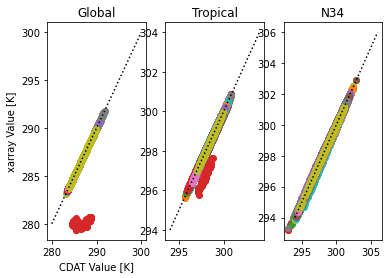

In [9]:
for i, region in enumerate(regions):
    print(region)
    plt.subplot(1, 3, i+1)
    X = cdatDict[region]
    Y = xrDict[region]
    for model in models:
        rip = list(global_cdat[model].keys())[0]
        x = np.array(X[model][rip])
        y = np.array(Y[model][rip])
        if len(y.shape) > 1:
            stop
        if y[0] > 1000:
            continue
        plt.scatter(x, y)
        n = len(x)
        r = np.corrcoef(x, y)[0, 1]
        rms = np.sqrt(np.mean((x-y)**2))
        md = np.mean(x-y)
        if ((r < 0.99) | (rms > 0.01) | (np.abs(md) > 0.01)):
            print(model, n, r, rms, md)
    plt.plot(pbounds[i], pbounds[i], 'k:')
    if i == 0:
        plt.xlabel('CDAT Value [K]')
        plt.ylabel('xarray Value [K]')
    plt.title(region)

Lots of models do not *exactly* match between xarray and CDAT, though NorCPM1 has a problem...let's look at this.

In [10]:
model = 'NorCPM1'
modelPaths = [p for p in dpaths if '/' + model + '/' in p]
rip = list(global_cdat[model].keys())[0]
dpath = [p for p in modelPaths if '/' + rip + '/' in p]
ds = xr.open_mfdataset(dpath[0] + '*nc')
tas = ds['tas']
print(tas.lat)
ds.close()

<xarray.DataArray 'lat' (lat: 142)>
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -31.263158, -29.368421, -27.473684, -27.473684,
       -25.578947, -23.684211, -21.789474, -21.789474, -19.894737, -19.894737,
       -18.      , -18.      , -16.105263, -14.210526, -14.210526, -12.315789,
       -12.315789, -10.421053, -10.421053,  -8.526316,  -8.526316,  -6.631579,
        -6.631579,  -4.736842,  -4.736842,  -2.842105,  -2.842105,  -0.947368,
        -0.947368,   0.947368,   0.947368,   2.842105,   2.842105,   4.736842,
         4.736842,   6.631579,   6.631579,   8.526316,   8.526316,  10.421053,
        10.42105

The problem may be that NorCPM's latitude grid is...weird? This is a problem for another day. The imperfect match between CDAT / xarray may be because the tropical / Niño 3.4 regions do not align perfectly with the model grids, which means xarray is not properly weighting the regional gridcells to account for partial grid overlap.

## Some notes

* CDAT had some issues with I/O (could not load KIOST-ESM r1i1p1f1)
* There is a need to develop more sophisticated averaging for xarray, particularly for regional averages
* xarray is faster (by nearly a factor of two)
* There are methods of extending xarray with relative ease